<a href="https://colab.research.google.com/github/karishmasandupatla/Handwritten-Digit-Locker/blob/main/Handwritten_Digit_Locker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Handwritten Digit Locker (with Fine-tuning)**

This project implements a **digit recognition system** using a deep learning model trained on **my own handwritten digits dataset**.  
The trained model acts as a "locker" — it only unlocks when the correct handwritten digit is detected.

- Framework: TensorFlow / Keras  
- Additional Tools: OpenCV, NumPy, Matplotlib  
- Dataset: Custom handwritten digits dataset  




##**Dataset Details**
- **Source**: Self-created handwritten digits collected on paper, scanned, and saved as image files.
- **Classes**: Digits from 0 to 9 and add K alphabet.
- **Format**: Images stored in folders corresponding to digit labels.
- **Note**: The dataset is not included in this repository due to storage constraints.  
  You can replace it with your own handwritten digit dataset in the same folder structure.



## ** Project Flow**
1. Import Libraries  
2. Load and Preprocess Data  
3. Build the Deep Learning Model  
4. Train the Model  
5. Evaluate Performance  
6. Simulate the Locker Unlock Process
7. Fine Tuning (adding data in existing folder and training data,evaluate,stimulate unlock process)


##**1. Import Libraries**  , **2. Load and Preprocess Data**


   - TensorFlow/Keras, NumPy, OpenCV, Matplotlib, os, glob.
   - Set seeds, GPU check (optional).

     - Folder structure:
     ```
     dataset/
       train/
         0/ 1/ ... 9
       validation/
         0/ 1/ ... 9
     ```
   - Steps: read images ➝ grayscale/RGB (match model) ➝ resize (e.g., 150×150) ➝ normalize [0,1].
   - Use `ImageDataGenerator` for augmentation and `flow_from_directory`.

Saving 9.jpeg to 9.jpeg
🔍 Total contours found: 893


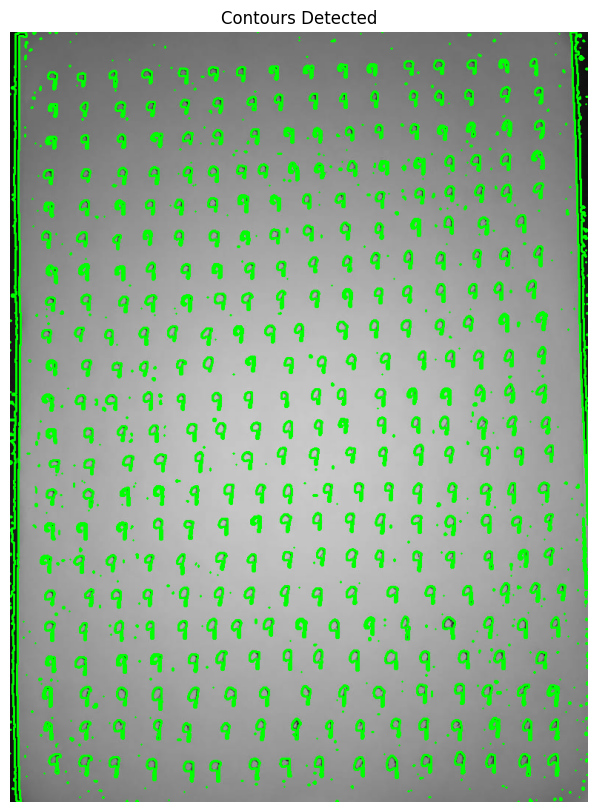

✅ Saved 352 digits to '/content/drive/MyDrive/All_Digits/train/9'
🚫 Rejected 541 due to size


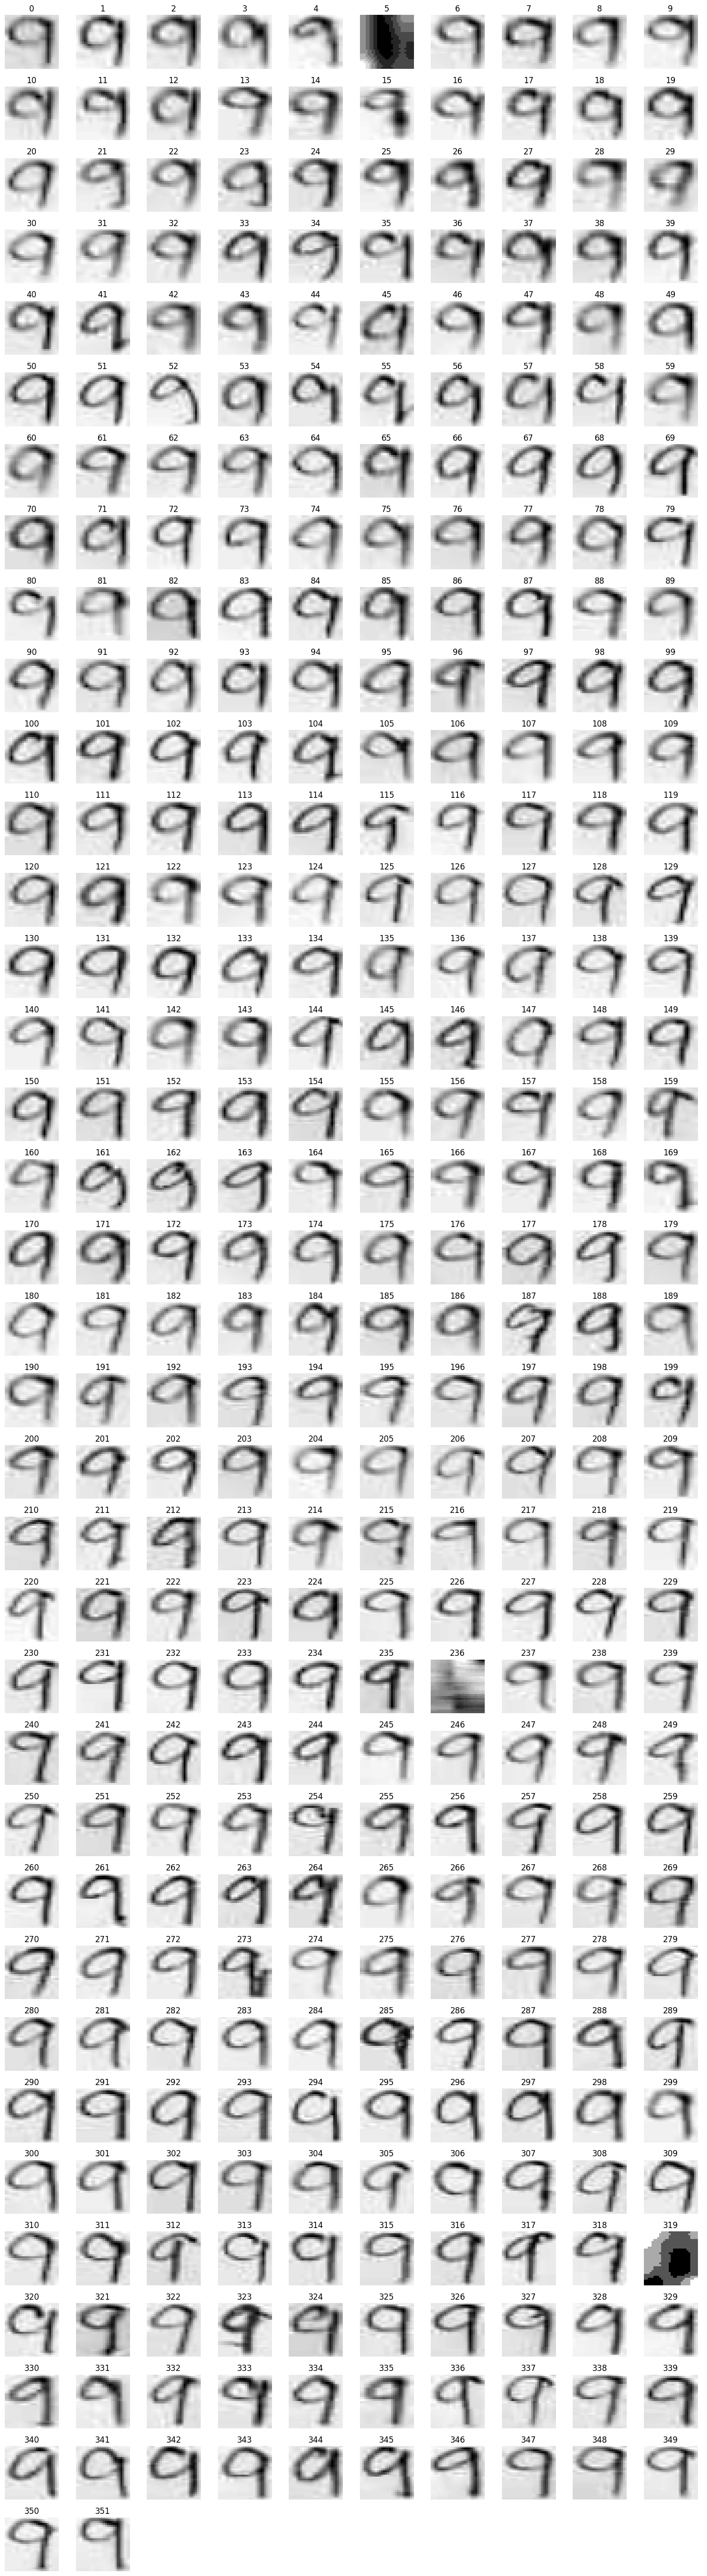

In [ ]:
# ✅ Step 1: Upload and Import Libraries
from google.colab import files
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import math
from IPython.display import Image, display

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# ✅ Step 2: Convert to Grayscale and Apply Threshold
image = cv2.imread(image_path)

# Ensure it’s in grayscale
if len(image.shape) == 3:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    gray = image.copy()

# Apply Gaussian Blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Adaptive Thresholding for better separation
thresh = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, 11, 2
)

# Close gaps in digits (morphology)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# ✅ Step 3: Find Contours
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"🔍 Total contours found: {len(contours)}")

# Optional: visualize contours
contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(contour_img)
plt.title("Contours Detected")
plt.axis("off")
plt.show()

##**2. Load and Preprocess Data**
# ✅ Step 4: Extract and Save Digits
output_folder = "/content/drive/MyDrive/All_Digits/train/9"
os.makedirs(output_folder, exist_ok=True)

# Avoid overwriting
existing_files = [f for f in os.listdir(output_folder) if f.endswith('.png')]
existing_ids = [int(f.split('_')[1].split('.')[0]) for f in existing_files if '_' in f]
digit_number = max(existing_ids) + 1 if existing_ids else 0

# Sort contours for consistent order
contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1] // 10, cv2.boundingRect(c)[0]))

saved_paths = []
rejected = 0

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if 5 < w < 100 and 5 < h < 100:
        digit_img = gray[y:y+h, x:x+w]
        digit_img_resized = cv2.resize(digit_img, (28, 28))
        output_path = os.path.join(output_folder, f'digit_{digit_number:03d}.png')
        cv2.imwrite(output_path, digit_img_resized)
        saved_paths.append(output_path)
        digit_number += 1
    else:
        rejected += 1

print(f"✅ Saved {len(saved_paths)} digits to '{output_folder}'")
print(f"🚫 Rejected {rejected} due to size")

# ✅ Step 5: Display Extracted Digits in Grid
num_images = len(saved_paths)
cols = 10
rows = math.ceil(num_images / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
axes = axes.flatten()

for i in range(num_images):
    img = cv2.imread(saved_paths[i], cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"{i}")
    axes[i].axis('off')

# Fill remaining cells
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("all_digits_grid.png")
plt.show()



##**3. Build the Deep Learning Model** , **4. Train the Model**  

 - CNN (Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense → Dropout → Dense).
   - Input shape: **(150, 150, 3)** (or your chosen size).
   - Output units: **11** (digits 0–9).
   - Compile: `optimizer='adam'`, `loss='categorical_crossentropy'`, `metrics=['accuracy']`.

   - Fit with `train_generator` and `validation_generator`.
   - Callbacks: `ModelCheckpoint` (save best), `EarlyStopping` (optional).
   - Save best weights: `models/best_model.h5`.

Found 3368 images belonging to 10 classes.
Found 245 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1140 - loss: 2.2937

106/106 ━━━━━━━━━━━━━━━━━━━━ 1130s 11s/step - accuracy: 0.1139 - loss: 2.2936 - val_accuracy: 0.0816 - val_loss: 2.3126
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1259 - loss: 2.2661

106/106 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.1260 - loss: 2.2660 - val_accuracy: 0.2204 - val_loss: 2.0127
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2117 - loss: 2.1447

106/106 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.2119 - loss: 2.1441 - val_accuracy: 0.4776 - val_loss: 1.6215
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3141 - loss: 1.9137

106/106 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3143 - loss: 1.9133 - val_accuracy: 0.6857 - val_loss: 1.1231
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4010 - loss: 1.6948

106/106 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.4011 - loss: 1.6947 - val_accuracy: 0.7388 - val_loss: 0.9095
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4354 - loss: 1.5556

106/106 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.4354 - loss: 1.5555 - val_accuracy: 0.8490 - val_loss: 0.6932
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4648 - loss: 1.4876

106/106 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.4648 - loss: 1.4875 - val_accuracy: 0.8776 - val_loss: 0.6118
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.5176 - loss: 1.3810 - val_accuracy: 0.8367 - val_loss: 0.5384
Epoch 9/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5263 - loss: 1.3193 - val_accuracy: 0.8449 - val_loss: 0.4921
Epoch 10/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.5592 - loss: 1.2344 - val_accuracy: 0.8653 - val_loss: 0.4463
Epoch 11/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.5627 - loss: 1.2180 - val_accuracy: 0.8327 - val_loss: 0.4878
Epoch 12/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5775 - loss: 1.1531

106/106 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.5776 - loss: 1.1532 - val_accuracy: 0.9143 - val_loss: 0.3394
Epoch 13/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5940 - loss: 1.1264 - val_accuracy: 0.8816 - val_loss: 0.4126
Epoch 14/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.6231 - loss: 1.0469 - val_accuracy: 0.8898 - val_loss: 0.3325
Epoch 15/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6473 - loss: 1.0545

106/106 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6474 - loss: 1.0541 - val_accuracy: 0.9388 - val_loss: 0.2787
Epoch 16/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6514 - loss: 1.0179 - val_accuracy: 0.9388 - val_loss: 0.2317
Epoch 17/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6527 - loss: 0.9942 - val_accuracy: 0.9061 - val_loss: 0.3307
Epoch 18/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.6781 - loss: 0.9141 - val_accuracy: 0.9388 - val_loss: 0.2326
Epoch 19/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6663 - loss: 0.9539

106/106 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6663 - loss: 0.9538 - val_accuracy: 0.9592 - val_loss: 0.1946
Epoch 20/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.6816 - loss: 0.9031 - val_accuracy: 0.9510 - val_loss: 0.2025
Epoch 21/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6879 - loss: 0.8976

106/106 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6879 - loss: 0.8976 - val_accuracy: 0.9673 - val_loss: 0.2059
Epoch 22/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.6944 - loss: 0.8828 - val_accuracy: 0.9673 - val_loss: 0.1637
Epoch 23/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.7149 - loss: 0.8384 - val_accuracy: 0.9673 - val_loss: 0.1669
Epoch 24/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6990 - loss: 0.8457

106/106 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6991 - loss: 0.8456 - val_accuracy: 0.9796 - val_loss: 0.1454
Epoch 25/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7058 - loss: 0.8279 - val_accuracy: 0.9551 - val_loss: 0.1517
Epoch 26/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6982 - loss: 0.8637 - val_accuracy: 0.9592 - val_loss: 0.1548
Epoch 27/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7359 - loss: 0.7598 - val_accuracy: 0.9796 - val_loss: 0.1197
Epoch 28/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.7404 - loss: 0.7590 - val_accuracy: 0.9714 - val_loss: 0.1100
Epoch 29/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7520 - loss: 0.7242 - val_accuracy: 0.9633 - val_loss: 0.1132
Epoch 30/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7552 - loss: 0.7128

106/106 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.7551 - loss: 0.7130 - val_accuracy: 0.9918 - val_loss: 0.0957
Final Training Accuracy: 74.94%
Final Validation Accuracy: 99.18%


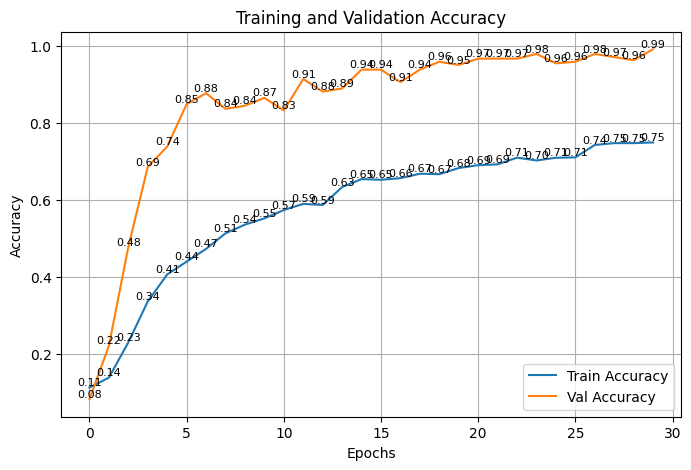

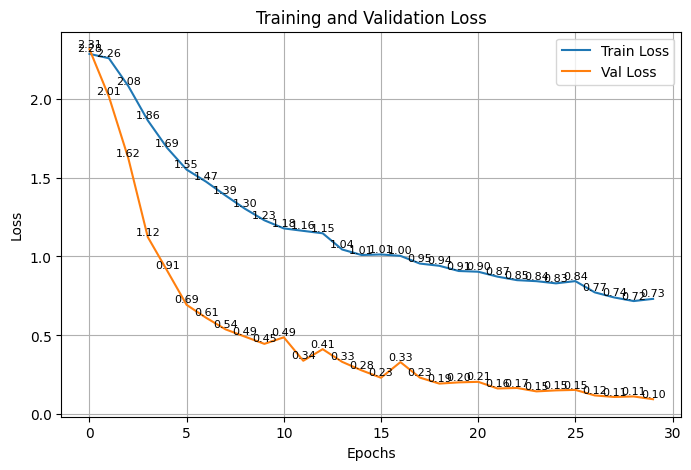

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Paths
TRAIN_DIR = '/content/drive/MyDrive/All_Digits/train'
VALIDATION_DIR = '/content/drive/MyDrive/All_Digits/Validation'

# Parameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 30

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model.h5', monitor='val_accuracy', save_best_only=True)

# Training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Display final accuracies
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
for i, acc in enumerate(history.history['accuracy']):
    plt.text(i, acc, f"{acc:.2f}", fontsize=8, ha='center', va='bottom')
for i, acc in enumerate(history.history['val_accuracy']):
    plt.text(i, acc, f"{acc:.2f}", fontsize=8, ha='center', va='bottom')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
for i, loss in enumerate(history.history['loss']):
    plt.text(i, loss, f"{loss:.2f}", fontsize=8, ha='center', va='bottom')
for i, loss in enumerate(history.history['val_loss']):
    plt.text(i, loss, f"{loss:.2f}", fontsize=8, ha='center', va='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


##**Import Libraries**

In [ ]:
!pip install tensorflowjs

## **5.Evaluate Performance**

   - Final train/val accuracy & loss plots.
   - Optional: confusion matrix and per-class accuracy.
   - Quick sanity-check predictions on a few samples.

Saving e2232cee-cdc4-4940-9b67-08c7adabb920.jpeg to e2232cee-cdc4-4940-9b67-08c7adabb920.jpeg

📂 Processing file: e2232cee-cdc4-4940-9b67-08c7adabb920.jpeg


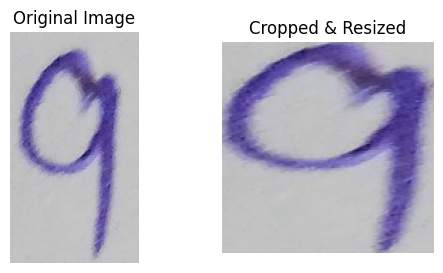

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
📊 Model prediction vector: [[1.0201992e-06 4.1862260e-09 5.7649302e-10 2.9874327e-09 1.3027191e-05
  2.1960150e-06 3.6714174e-09 9.4316259e-04 2.9986228e-12 9.9904054e-01]]
✅ Predicted digit: 9


In [ ]:
from google.colab import files
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

# ✅ Load trained model (make sure you've uploaded this)
model = load_model('/content/drive/MyDrive/best_model.h5')  # ← Use your actual model filename here

# ✅ Upload handwritten digit images
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f"\n📂 Processing file: {file_name}")

    # Step 1: Read image in color
    img = cv2.imread(file_name) # Load in color
    if img is None:
        print(f"⚠️ Error reading {file_name}")
        continue

    # Step 2: Convert to grayscale for preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 3: Invert image — make digit white on black (like MNIST)
    img_inverted = cv2.bitwise_not(gray)

    # Step 4: Thresholding to get binary image
    _, binary = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 5: Crop digit using bounding box
    coords = cv2.findNonZero(binary)
    if coords is None:
        print(f"⚠️ No digit found in {file_name}")
        continue
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w] # Crop from color image

    # Step 6: Resize to model's expected input size (150x150)
    resized = cv2.resize(cropped, (150, 150), interpolation=cv2.INTER_AREA)

    # Debug display: Preprocessed input
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Display original in color
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Cropped & Resized")
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)) # Display resized in color
    plt.axis('off')
    plt.show()

    # Step 7: Normalize and reshape input for model
    input_img = resized.astype("float32") / 255.0
    input_img = np.expand_dims(input_img, axis=0)   # (1, 150, 150, 3)

    # Step 8: Predict digit
    prediction = model.predict(input_img)
    predicted_digit = np.argmax(prediction)

    # Debug: Print prediction vector
    print("📊 Model prediction vector:", prediction)
    print("✅ Predicted digit:", predicted_digit)

Saving c07107c4-0cd2-4c66-b1ba-73a7c736581c.jpeg to c07107c4-0cd2-4c66-b1ba-73a7c736581c.jpeg

📂 Processing: c07107c4-0cd2-4c66-b1ba-73a7c736581c.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


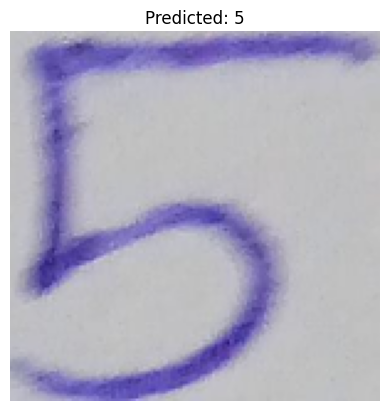

✅ Predicted class: 5


In [ ]:
from google.colab import files
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model('/content/drive/MyDrive/best_model.h5')  # ← Adjust if needed
class_names = [str(i) for i in range(10)]  # for digits 0-9; update if you have different classes

# Upload image(s)
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f"\n📂 Processing: {file_name}")

    try:
        # Read as color image
        img = cv2.imread(file_name)
        if img is None:
            raise ValueError("⚠️ Image read error")

        # Convert to grayscale, invert, and binarize
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        inverted = cv2.bitwise_not(gray)
        _, binary = cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Crop digit using bounding box
        coords = cv2.findNonZero(binary)
        if coords is None:
            raise ValueError("⚠️ No digit found")
        x, y, w, h = cv2.boundingRect(coords)
        cropped = img[y:y+h, x:x+w]

        # Resize and normalize
        resized = cv2.resize(cropped, (150, 150))
        input_img = resized.astype("float32") / 255.0
        input_img = np.expand_dims(input_img, axis=0)

        # Predict
        prediction = model.predict(input_img)
        predicted_class = class_names[np.argmax(prediction)]

        # Show result
        plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

        print("✅ Predicted class:", predicted_class)

    except Exception as e:
        print(str(e))


## **6.Simulate the Locker Unlock Process**

  - Two modes:
     - **Single image** ➝ predict one character (0–9).
     - **One-line image** ➝ segment contours left→right ➝ predict each ➝ build PIN string.
   - Compare predicted PIN to `correct_pin` ➝ **Unlock / Denied**.

**Single image** ➝ predict one character (0–9).


📥 Upload digit 1 of 4


Saving e2232cee-cdc4-4940-9b67-08c7adabb920.jpeg to e2232cee-cdc4-4940-9b67-08c7adabb920 (4).jpeg
📂 Processing: e2232cee-cdc4-4940-9b67-08c7adabb920 (4).jpeg


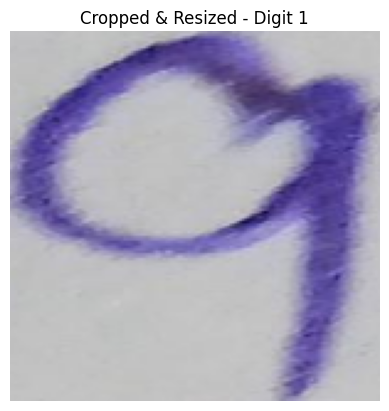


📥 Upload digit 2 of 4


Saving 24f33f73-1f54-420f-ba45-7942340493d9.jpeg to 24f33f73-1f54-420f-ba45-7942340493d9 (1).jpeg
📂 Processing: 24f33f73-1f54-420f-ba45-7942340493d9 (1).jpeg



📥 Upload digit 3 of 4


Saving b95e5af0-c3a4-42c1-9d1e-11c7233eea64.jpeg to b95e5af0-c3a4-42c1-9d1e-11c7233eea64 (1).jpeg
📂 Processing: b95e5af0-c3a4-42c1-9d1e-11c7233eea64 (1).jpeg



📥 Upload digit 4 of 4


Saving 036b5d2b-a35b-464f-ab2a-8bd0bf5b424c.jpeg to 036b5d2b-a35b-464f-ab2a-8bd0bf5b424c (1).jpeg
📂 Processing: 036b5d2b-a35b-464f-ab2a-8bd0bf5b424c (1).jpeg


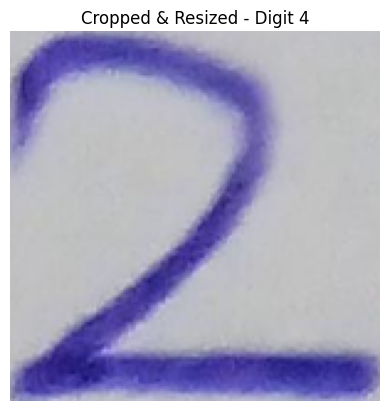


🔐 Predicted PIN sequence: 9402
🔐 Correct PIN: 9402
✅ Access Granted – UNLOCKED


In [ ]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

# ✅ Step 1: Load trained CNN model
model = load_model('/content/drive/MyDrive/best_model.h5')  # replace with your model filename

# ✅ Step 2: Define the correct PIN
correct_pin = "9402"

# ✅ Step 3: Expected number of digits
num_digits = len(correct_pin)

predicted_sequence = ""

# ✅ Step 4: Upload one-by-one
for i in range(num_digits):
    print(f"\n📥 Upload digit {i+1} of {num_digits}")
    uploaded = files.upload()

    file_name = list(uploaded.keys())[0]
    print(f"📂 Processing: {file_name}")

    # Read and preprocess
    img = cv2.imread(file_name) # Read as color image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale for preprocessing
    img_inverted = cv2.bitwise_not(gray)
    _, binary = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w] # Crop from color image
    resized = cv2.resize(cropped, (150, 150), interpolation=cv2.INTER_AREA) # Resize to 150x150

    # Show image
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)) # Display resized image in color
    plt.title(f"Cropped & Resized - Digit {i+1}")
    plt.axis('off')
    plt.show()

    # Normalize and reshape
    input_img = resized.astype("float32") / 255.0
    input_img = np.expand_dims(input_img, axis=0) # Add batch dimension (1, 150, 150, 3)

    # Predict digit
    prediction = model.predict(input_img, verbose=0)
    predicted_digit = str(np.argmax(prediction))
    predicted_sequence += predicted_digit

# ✅ Step 5: Final PIN check
print("\n🔐 Predicted PIN sequence:", predicted_sequence)
print("🔐 Correct PIN:", correct_pin)

if predicted_sequence == correct_pin:
    print("✅ Access Granted – UNLOCKED")
else:
    print("❌ Access Denied – LOCKED")


**One-line image** ➝ segment contours left→right ➝ predict each ➝ build PIN string.
Compare predicted PIN to correct_pin ➝ Unlock / Denied.

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# ✅ Load model
model = load_model('/content/drive/MyDrive/best_model.h5')  # Update path if needed

# ✅ Correct PIN
correct_pin = "9402"  # Change this to your actual PIN

# ✅ Upload digit line image
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ✅ Read and preprocess image
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(255 - blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ✅ Find contours (digits)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(c) for c in contours]
bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])  # sort by x (left to right)

predicted_digits = ""

plt.figure(figsize=(15, 3))

for i, (x, y, w, h) in enumerate(bounding_boxes):
    digit = img[y:y+h, x:x+w]
    digit_resized = cv2.resize(digit, (150, 150))  # match model input size
    digit_normalized = digit_resized.astype("float32") / 255.0
    digit_input = np.expand_dims(digit_normalized, axis=0)  # shape: (1, 150, 150, 3)

    pred = model.predict(digit_input, verbose=0)
    predicted_class = np.argmax(pred)
    predicted_digits += str(predicted_class)

    # 🖼️ Plot digit
    plt.subplot(1, len(bounding_boxes), i + 1)
    plt.imshow(cv2.cvtColor(digit_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 🔐 PIN Check
print("\nPredicted PIN Sequence:", predicted_digits)
if predicted_digits == correct_pin:
    print("✅ PIN Matched! 🔓 Unlocking Key...")
else:
    print("❌ PIN Incorrect! 🔒 Key Locked.")


Saving 014ebd08-c2bb-4ccd-9f1d-115a16636d1d.jpeg to 014ebd08-c2bb-4ccd-9f1d-115a16636d1d (1).jpeg



Predicted PIN Sequence: 9402
✅ PIN Matched! 🔓 Unlocking Key...


# **7. Fine-Tuning**


**Fine-Tuning with New Data but same folder**
*   a) Add Data
*   b) Retrain
*   c) Evaluate
*   d) Simulate










**a) Add Data**

##**1. Import Libraries**  , **2. Load  New and Preprocess Data into Existing Same  Folder above Made**
Add Data – Put extra samples of weak classes (e.g., K) into:
*   dataset/train/K/
*   dataset/validation/K/




Saving K.jpeg to K (1).jpeg
🔍 Total contours found: 868


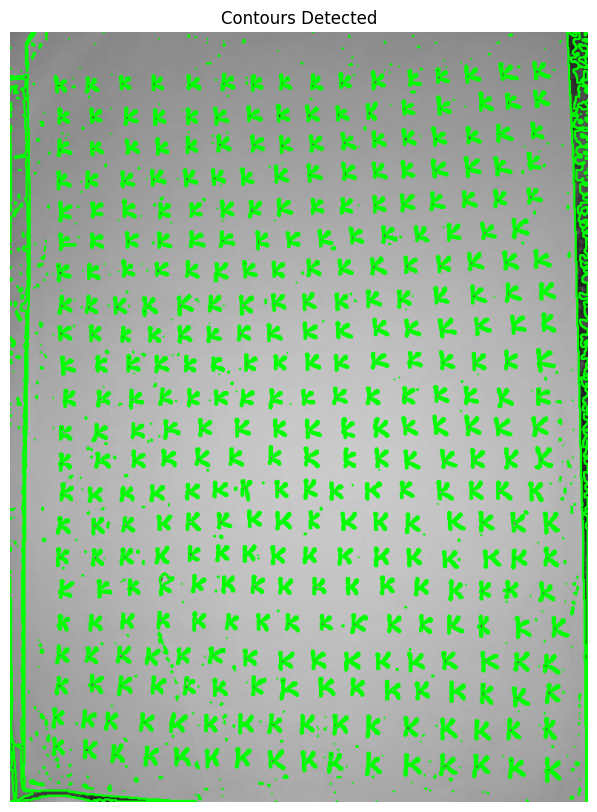

✅ Saved 366 digits to '/content/drive/MyDrive/All_Digits/train/K'
🚫 Rejected 502 due to size


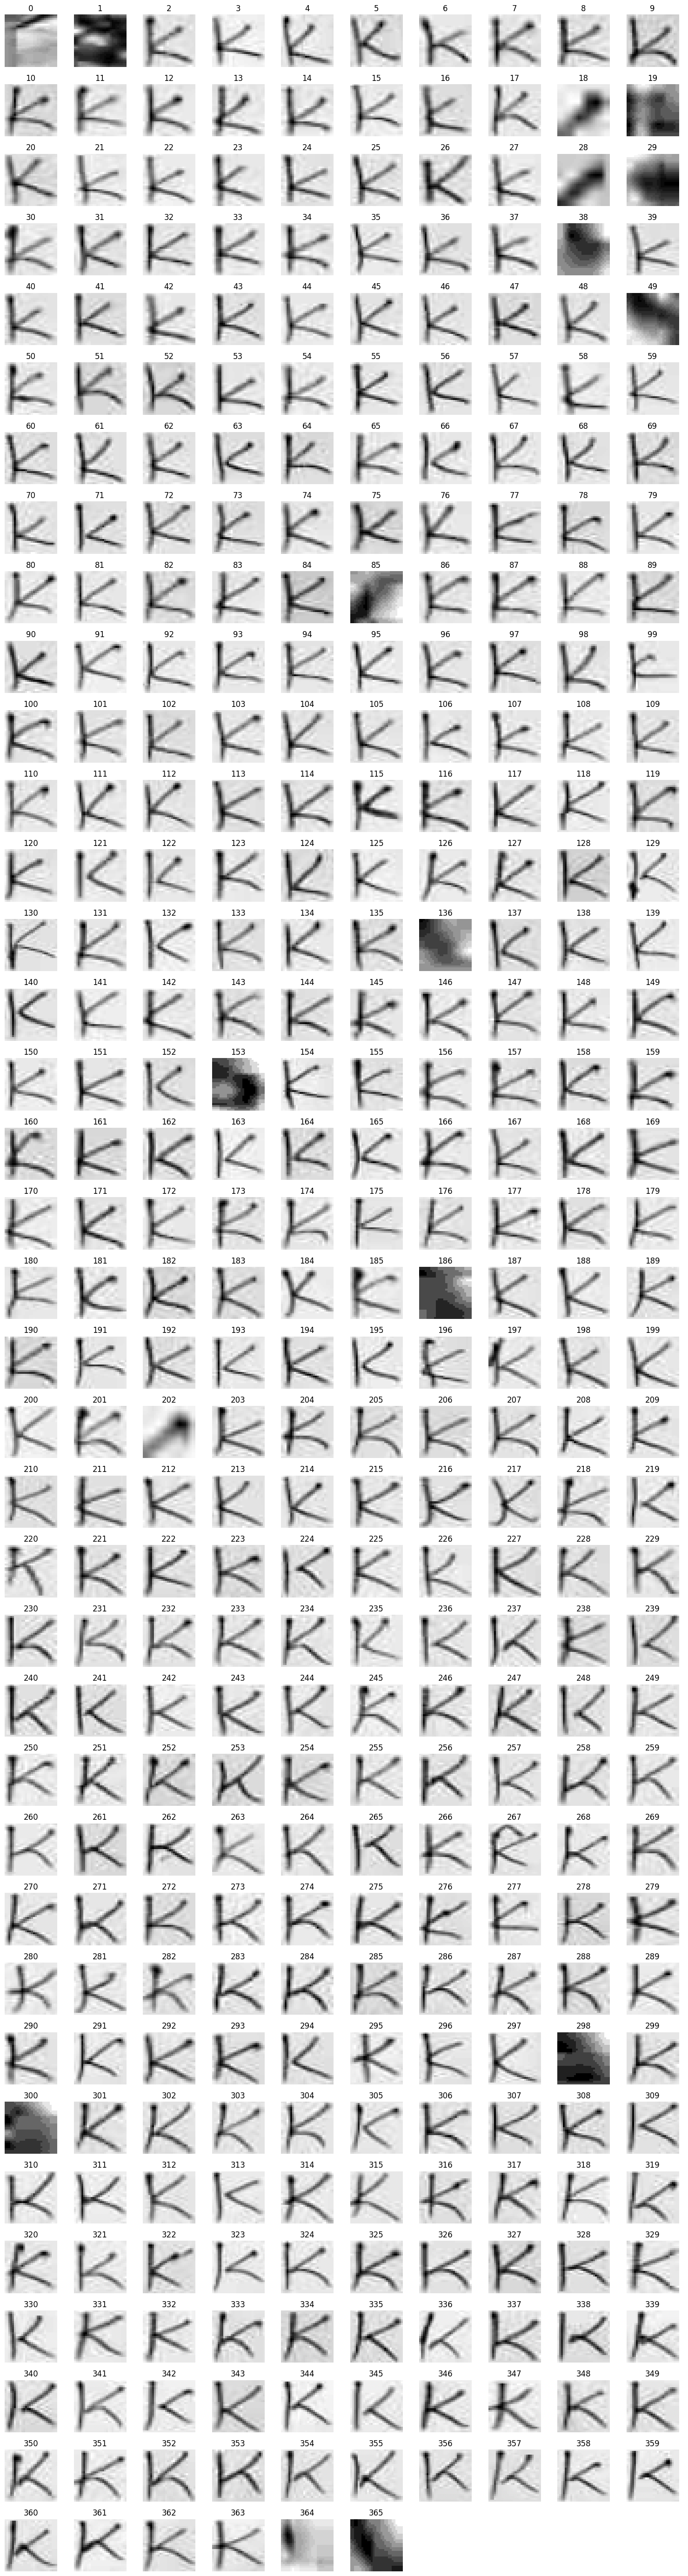

In [ ]:
# ✅ Step 1: Upload and Import Libraries
from google.colab import files
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import math
from IPython.display import Image, display

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# ✅ Step 2: Convert to Grayscale and Apply Threshold
image = cv2.imread(image_path)

# Ensure it’s in grayscale
if len(image.shape) == 3:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    gray = image.copy()

# Apply Gaussian Blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Adaptive Thresholding for better separation
thresh = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, 11, 2
)

# Close gaps in digits (morphology)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# ✅ Step 3: Find Contours
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"🔍 Total contours found: {len(contours)}")

# Optional: visualize contours
contour_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(contour_img)
plt.title("Contours Detected")
plt.axis("off")
plt.show()

##**2. Load and Preprocess Data**
# ✅ Step 4: Extract and Save Digits
output_folder = "/content/drive/MyDrive/All_Digits/train/K"
os.makedirs(output_folder, exist_ok=True)

# Avoid overwriting
existing_files = [f for f in os.listdir(output_folder) if f.endswith('.png')]
existing_ids = [int(f.split('_')[1].split('.')[0]) for f in existing_files if '_' in f]
digit_number = max(existing_ids) + 1 if existing_ids else 0

# Sort contours for consistent order
contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1] // 10, cv2.boundingRect(c)[0]))

saved_paths = []
rejected = 0

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if 5 < w < 100 and 5 < h < 100:
        digit_img = gray[y:y+h, x:x+w]
        digit_img_resized = cv2.resize(digit_img, (28, 28))
        output_path = os.path.join(output_folder, f'digit_{digit_number:03d}.png')
        cv2.imwrite(output_path, digit_img_resized)
        saved_paths.append(output_path)
        digit_number += 1
    else:
        rejected += 1

print(f"✅ Saved {len(saved_paths)} digits to '{output_folder}'")
print(f"🚫 Rejected {rejected} due to size")

# ✅ Step 5: Display Extracted Digits in Grid
num_images = len(saved_paths)
cols = 10
rows = math.ceil(num_images / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
axes = axes.flatten()

for i in range(num_images):
    img = cv2.imread(saved_paths[i], cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"{i}")
    axes[i].axis('off')

# Fill remaining cells
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("all_digits_grid.png")
plt.show()


**b) Retrain**


**Retrain the Model with taking consideration of Last model**
*   Continue Training – Reload best model → set lower learning rate → train a few more epochs.





In [ ]:
# ✅ Step 1: Import libraries
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Paths
TRAIN_DIR = '/content/drive/MyDrive/All_Digits/train'        # contains 0-9 + K
VALIDATION_DIR = '/content/drive/MyDrive/All_Digits/Validation'  # contains 0-9 + K

# Parameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 10   # fewer since we are fine-tuning
LEARNING_RATE = 1e-4   # smaller LR for fine-tuning


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("✅ Classes found:", train_generator.class_indices)


Found 3734 images belonging to 11 classes.
Found 272 images belonging to 11 classes.
✅ Classes found: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'K': 10}


In [ ]:
# Load your previous trained CNN
old_model = load_model('/content/drive/MyDrive/best_model.h5')
old_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,644 (18.42 MB)

 Trainable params: 4,829,642 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
for layer in old_model.layers[:-1]:  # freeze all except last layer
    layer.trainable = False


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Input

# Load your previous trained CNN
old_model = load_model('/content/drive/MyDrive/best_model.h5')
old_model.summary()

# Create a new model by taking the output of the penultimate layer of the old model
# and adding a new dense layer with the correct number of classes.
# Explicitly define the input layer for the new model.
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)) # Define input shape
x = old_model.layers[0](input_tensor) # Pass the input through the first layer of the old model
for layer in old_model.layers[1:-1]: # Pass through the rest of the layers except the last one
    x = layer(x)
new_output = Dense(11, activation='softmax')(x)  # 11 classes (0-9 + K)

model = Model(inputs=input_tensor, outputs=new_output)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,644 (18.42 MB)

 Trainable params: 4,829,642 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,771 (18.42 MB)

 Trainable params: 4,829,771 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8186 - loss: 0.4792 - val_accuracy: 0.9816 - val_loss: 0.0857
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8511 - loss: 0.4008 - val_accuracy: 0.9853 - val_loss: 0.0729
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.8541 - loss: 0.4012 - val_accuracy: 0.9853 - val_loss: 0.0759
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8347 - loss: 0.4258 - val_accuracy: 0.9853 - val_loss: 0.0767
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.8556 - loss: 0.3969 - val_accuracy: 0.9890 - val_loss: 0.0582
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8578 - loss: 0.3785 - val_accuracy: 0.9890 - val_loss: 0.0550
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.8467 - loss: 0.3978 - val_accuracy: 0.9890 - val_loss: 0.0581
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8627 - loss: 0.3552 - val_accu

In [ ]:
model.save('/content/drive/MyDrive/best_model_with_K.h5')
print("✅ Fine-tuned model saved as best_model_with_K.h5")

✅ Fine-tuned model saved as best_model_with_K.h5


**c) Evaluate**
*   Re-Evaluate – Plot metrics, check confusion matrix, confirm improvements.




Saving 6f187310-59d9-4e1a-86df-99425b07dfe9.jpeg to 6f187310-59d9-4e1a-86df-99425b07dfe9 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
✅ Predicted Label: K


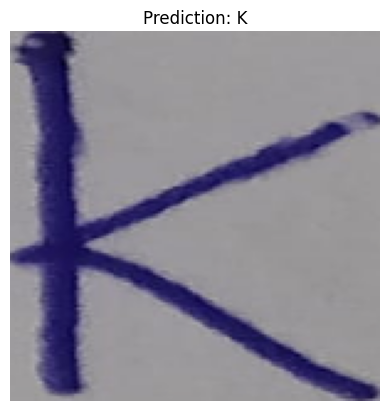

In [ ]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ✅ Load your trained CNN model
model = load_model('/content/drive/MyDrive/best_model_with_K.h5')  # update path if needed

# ✅ Define all class labels (0-9 + K)
class_labels = [str(i) for i in range(10)] + ["K"]  # ['0','1',...,'9','K']

# ✅ Upload image
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ✅ Read and preprocess image
img = cv2.imread(filename)
# Ensure image is in color (3 channels) for the model
if len(img.shape) == 2: # if grayscale
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(255 - blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours (digits) - assuming only one digit in the image for this cell
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Assuming the largest contour is the digit
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    digit_img = img[y:y+h, x:x+w] # Use the original color image for cropping
else:
    print("No contours found in the image.")
    digit_img = img # Use the whole image if no contours found


resized = cv2.resize(digit_img, (150, 150))  # Resize to match model input size (150, 150)
normalized = resized.astype("float32") / 255.0
reshaped = np.expand_dims(normalized, axis=0) # Add batch dimension (1, 150, 150, 3)


# ✅ Prediction
prediction = model.predict(reshaped)
predicted_class = np.argmax(prediction)
predicted_label = class_labels[predicted_class]

print(f"✅ Predicted Label: {predicted_label}")

# ✅ Show image with prediction
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)) # Display in color
plt.title(f"Prediction: {predicted_label}")
plt.axis("off")
plt.show()

**d) Simulate**

Retest Locker – Run prediction + PIN verification again to ensure robustness.

Saving 1b884581-45eb-4f1e-ac4c-fead78c817af.jpeg to 1b884581-45eb-4f1e-ac4c-fead78c817af.jpeg


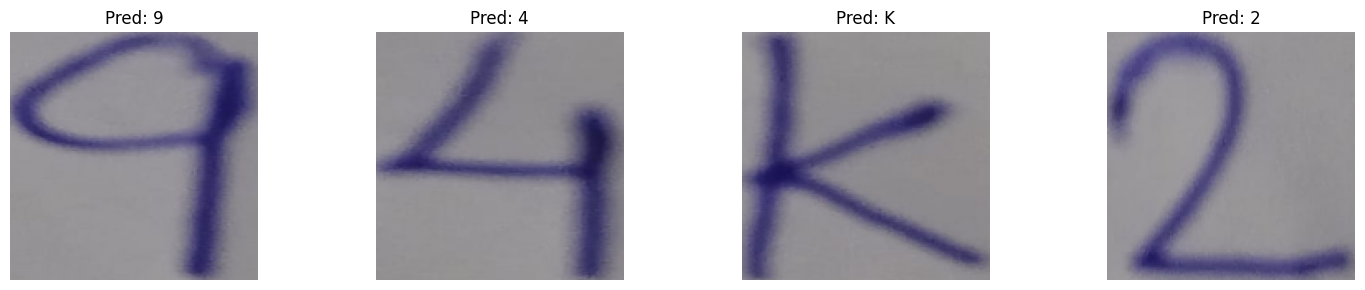


Predicted PIN Sequence: 94K2
✅ PIN Matched! 🔓 Unlocking Key...


In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ✅ Load model (supports 0–9 + K)
model = load_model('/content/drive/MyDrive/best_model_with_K.h5')

# ✅ Define labels (0–9 + K)
class_labels = [str(i) for i in range(10)] + ["K"]

# ✅ Correct PIN
correct_pin = "94K2"  # Change this to your actual PIN

# ✅ Upload digit line image
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ✅ Read and preprocess image
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(255 - blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ✅ Find contours (digits/characters)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(c) for c in contours]
bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])  # sort left → right

predicted_digits = ""

plt.figure(figsize=(15, 3))

for i, (x, y, w, h) in enumerate(bounding_boxes):
    digit = img[y:y+h, x:x+w]

    # ✅ Ensure 3 channels & resize
    digit_resized = cv2.resize(digit, (150, 150))
    digit_resized = cv2.cvtColor(digit_resized, cv2.COLOR_BGR2RGB)  # force RGB
    digit_normalized = digit_resized.astype("float32") / 255.0
    digit_input = np.expand_dims(digit_normalized, axis=0)  # (1, 150, 150, 3)

    # ✅ Prediction
    pred = model.predict(digit_input, verbose=0)
    predicted_class = np.argmax(pred)
    predicted_label = class_labels[predicted_class]

    predicted_digits += predicted_label

    # 🖼️ Plot each digit/char
    plt.subplot(1, len(bounding_boxes), i + 1)
    plt.imshow(digit_resized)
    plt.title(f"Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 🔐 PIN Check
print("\nPredicted PIN Sequence:", predicted_digits)
if predicted_digits == correct_pin:
    print("✅ PIN Matched! 🔓 Unlocking Key...")
else:
    print("❌ PIN Incorrect! 🔒 Key Locked.")




#**8. Conclusion**


* The handwritten digit/character locker system successfully demonstrates how
deep learning can be applied to secure authentication. By training, testing, and fine-tuning the model with diverse handwriting data, the system achieves reliable accuracy and robustness. This project highlights the potential of AI-driven solutions for real-world applications in security and access control.


#**Future Scope:**

*   The system can be enhanced with a UI using Streamlit/Flask, support real-time input, extend to multi-character passwords, and integrate advanced security features for practical use.




##**Objective**:
 Create a deep learning model for a handwritten digit/characterlocker that trains → exports → tests, and predicts inputs to unlock with a correct PIN.

##**Challenges**:
Data variability in handwriting, class imbalance, overfitting, ensuring high accuracy for secure unlock, and fine-tuning with new data.

##**Outcome**:
A robust CNN-based locker system that reliably recognizes handwritten digits/characters and unlocks only when the correct PIN is predicted.


```
# Project All About
```



# **This project demonstrates how deep learning can transform handwritten digits into a secure digital locker system, highlighting the cycle of training, evaluation, and real-world application.**



